In [92]:
from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs
import matplotlib.pyplot as plt
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
import numpy as np
from tqdm import tqdm
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc import waveform
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from pycbc.waveform import get_td_waveform, get_fd_waveform
import math
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
%run GW_functions.ipynb

In [94]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [95]:
def PNparams(M,q,d,f_low,e0,delta_t):
    M2=M/(1+q)
    M1=M2*q
    hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                             delta_t=delta_t, 
                             f_lower=f_low, 
                             eccentricity=e0,
                             distance=d)
    
    modetopolfac=4*(5/(64*np.pi))**(1/2)  #conversion factor between mode amplitude and strain amplitude
                                          # check 0704.3764 equation 7 for details
    M_SI = M * MSUN_SI
    D_SI = 10**6 * PC_SI * d
    phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
    tVec_PN=hpVec_PN.sample_times/(M*MTSUN_SI)
    fVec_PN=waveform.utils.frequency_from_polarizations(hpVec_PN, hcVec_PN)
    return phase_EccTD, tVec_PN

# $22$

In [144]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=0
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode2polfac=(5/(64*np.pi))**(1/2)
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=2
mp=2
    
j=0
h22=[]
h2_2=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h22.append(hlm)
    h2_2.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph22, sph2_2 = sph_harmonics(inc,lp)
    
h = np.multiply(h22,sph22) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode2polfac=(5/(64*np.pi))**(1/2)  
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp2 = np.arange(time[0], time[-1], delta_t)
hp_intrp2 = hp_intrp(t_intrp2)
hc_intrp2 = hc_intrp(t_intrp2)

100%|█████████████████████████████████████| 1376/1376 [00:01<00:00, 1134.15it/s]


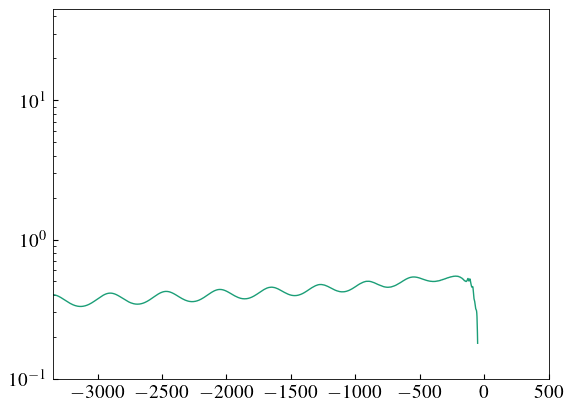

In [145]:
plt.yscale('log')
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.ylim(ymax=4.5e1)
plt.ylim(ymin=1e-1)
plt.plot(t_intrp2/(M0*MTSUN_SI),abs(hp_intrp2+1j*hc_intrp2)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac))

100%|█████████████████████████████████| 158636/158636 [02:20<00:00, 1127.66it/s]


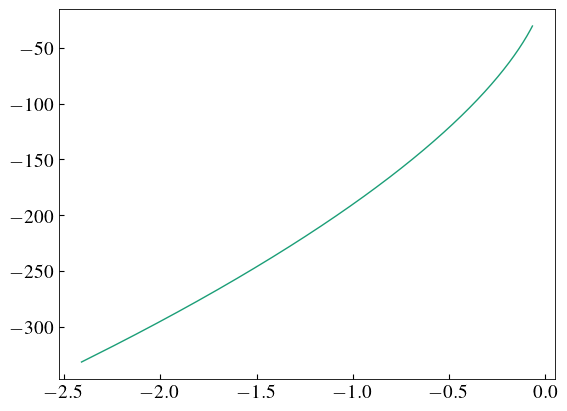

In [146]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.046415888336127795
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

phs=Time_data*Omega_avg
plt.plot(Time_data,phs)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec #[:10000]

phase_EccTD, tVec_PN = PNparams(M0,q,d0,21.541668606103567,e0,delta_t) #??

lp=2
mp=2
    
j=0
h22=[]
h2_2=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_22(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h22.append(hlm)
    h2_2.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph22, sph2_2 = sph_harmonics(inc,lp)
    
h = np.multiply(h22,sph22) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode2polfac=(5/(64*np.pi))**(1/2)  
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new2 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new2 = hp_intrp_new(t_intrp_new2)
hc_intrp_new2 = hc_intrp_new(t_intrp_new2)



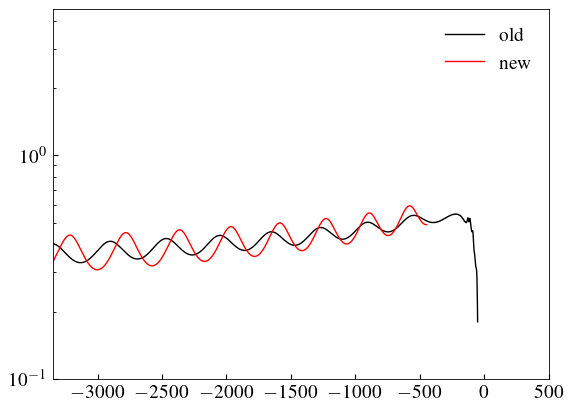

In [149]:
plt.yscale('log')
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.ylim(ymax=4.5e0)
plt.ylim(ymin=1e-1)
plt.plot(t_intrp2/(M0*MTSUN_SI),abs(hp_intrp2+1j*hc_intrp2)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),'k-',label='old')
plt.plot(t_intrp_new2/(M0*MTSUN_SI),abs(hp_intrp_new2+1j*hc_intrp_new2)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),'r-',label='new')
#print(hp_intrp_new2)
plt.legend()

# $33$

In [150]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode3polfac=(21/(2*np.pi))**(1/2) 
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=3
mp=3
    
j=0
h33=[]
h3_3=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h33.append(hlm)
    h3_3.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph33, sph3_3 = sph_harmonics(inc,lp)
    
h = np.multiply(h33,sph33) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode2polfac=(5/(64*np.pi))**(1/2)  
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp3 = np.arange(time[0], time[-1], delta_t)
hp_intrp3 = hp_intrp(t_intrp3)
hc_intrp3 = hc_intrp(t_intrp3)

100%|█████████████████████████████████████| 1376/1376 [00:00<00:00, 2132.64it/s]


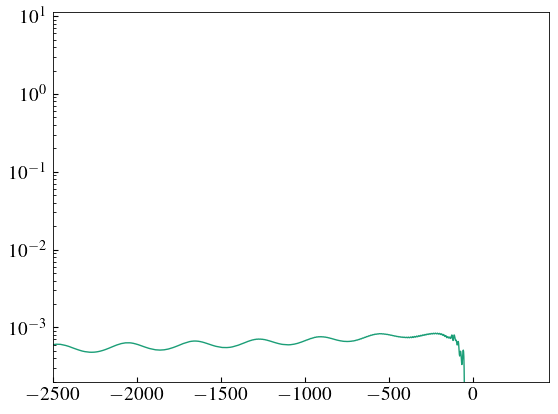

In [151]:
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp3/(M0*MTSUN_SI),abs(hp_intrp3+1j*hc_intrp3)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode3polfac))
#print(sph33)

100%|█████████████████████████████████| 158636/158636 [01:06<00:00, 2370.82it/s]


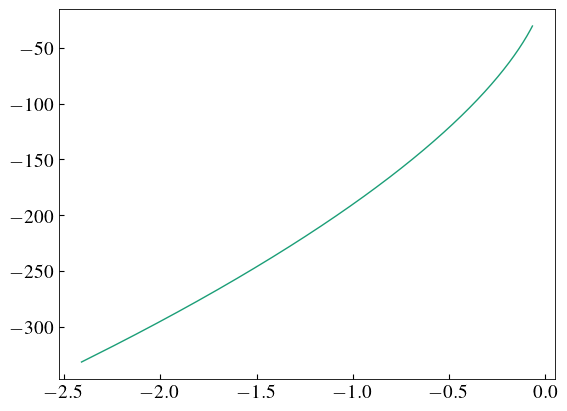

In [152]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.046415888336127795
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

phs=Time_data*Omega_avg
plt.plot(Time_data,phs)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec #[:10000]

phase_EccTD, tVec_PN = PNparams(M0,q,d0,21.541668606103567,e0,delta_t) #??

lp=3
mp=3
    
j=0
h33=[]
h3_3=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_33(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h33.append(hlm)
    h3_3.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph33, sph3_3 = sph_harmonics(inc,lp)
    
h = np.multiply(h33,sph33) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode3polfac=(21/(2*np.pi))**(1/2)
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new3 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new3 = hp_intrp_new(t_intrp_new3)
hc_intrp_new3 = hc_intrp_new(t_intrp_new3)



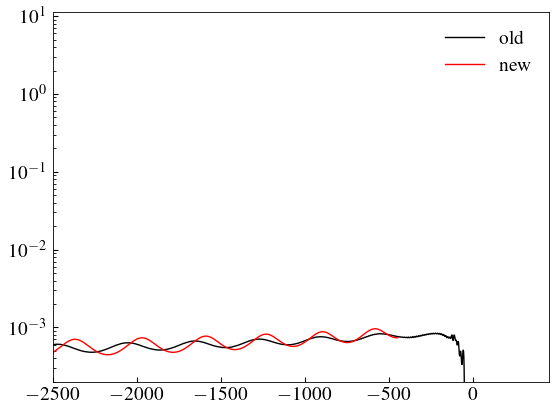

In [155]:
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp3/(M0*MTSUN_SI),abs(hp_intrp3+1j*hc_intrp3)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode3polfac),'k-',label='old')
plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode3polfac),'r-',label='new')
plt.legend()

# $44$

In [156]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode4polfac=(3/64)*(7/(1*np.pi))**(1/2)  
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=4
mp=4
    
j=0
h44=[]
h4_4=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h44.append(hlm)
    h4_4.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph44, sph4_4 = sph_harmonics(inc,lp)
    
h = np.multiply(h44,sph44)#+np.multiply(h4_4,sph4_4)
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode4polfac=(3/64)*(7/(1*np.pi))**(1/2) 
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp4 = np.arange(time[0], time[-1], delta_t)
hp_intrp4 = hp_intrp(t_intrp4)
hc_intrp4 = hc_intrp(t_intrp4)

100%|█████████████████████████████████████| 1376/1376 [00:00<00:00, 3072.44it/s]


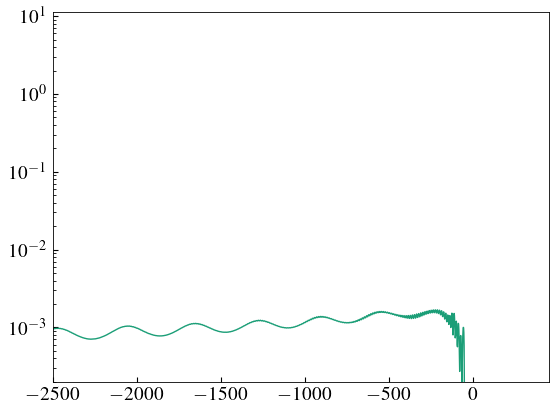

In [157]:
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp4/(M0*MTSUN_SI),abs(hp_intrp4+1j*hc_intrp4)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode4polfac))
#print(sph33)

100%|█████████████████████████████████| 158636/158636 [00:52<00:00, 3040.53it/s]


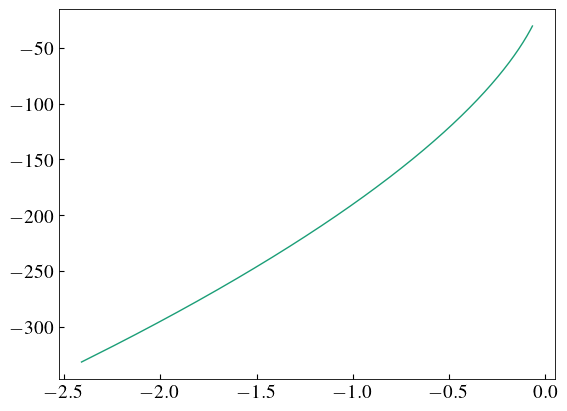

In [158]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.046415888336127795
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

phs=Time_data*Omega_avg
plt.plot(Time_data,phs)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec #[:10000]

phase_EccTD, tVec_PN = PNparams(M0,q,d0,21.541668606103567,e0,delta_t) #??

lp=4
mp=4
    
j=0
h44=[]
h4_4=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_44(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h44.append(hlm)
    h4_4.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph44, sph4_4 = sph_harmonics(inc,lp)
    
h = np.multiply(h44,sph44) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode4polfac=(3/64)*(7/(1*np.pi))**(1/2) 
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new4 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new4 = hp_intrp_new(t_intrp_new4)
hc_intrp_new4 = hc_intrp_new(t_intrp_new4)



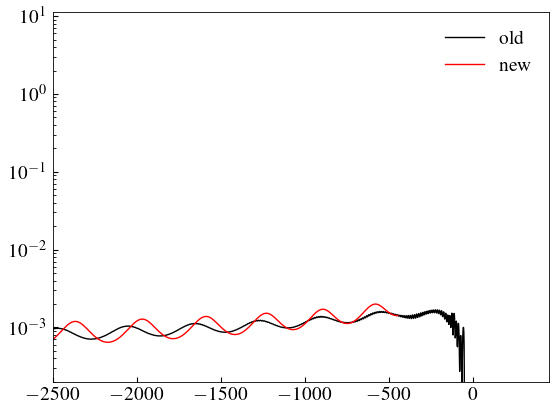

In [160]:
plt.yscale('log')
plt.yscale('log')
#plt.ylim(ymax=1e-1)
plt.ylim(ymin=2e-4)
plt.xlim(xmin=-2500)
plt.xlim(xmax=450)
plt.plot(t_intrp4/(M0*MTSUN_SI),abs(hp_intrp4+1j*hc_intrp4)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode4polfac),'k-',label='old')
plt.plot(t_intrp_new4/(M0*MTSUN_SI),abs(hp_intrp_new4+1j*hc_intrp_new4)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode4polfac),'r-',label='new')
plt.legend()

# $55$

In [161]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096

eta=neu=nu=q/(1+q)**2
G=c=M=d=1
M2=M/(1+q)
M1=M2*q
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma=0.577215664901
mode5polfac=(330/(1*np.pi))**(1/2)    
    
conv=M*MTSUN_SI
M_SI=M0 * MSUN_SI
D_SI=(10**(6)) * PC_SI * d
    
xlow = ((M0*MTSUN_SI*math.pi*flow)**(2/3))
f_low = (xlow**(3/2)/(M*MTSUN_SI*math.pi))
    
%run GW_functions.ipynb
    
x=xlow
v=math.sqrt(x)
    
xie=v**3
    
#if delta_t>=1/2**14:
    #del_t = 1/2**14
#elif delta_t<1/2**14 and delta_t>=1/2**16:
    #del_t = 1/2**16
#elif delta_t<1/2**16 and delta_t>=1/2**18:
    #del_t = 1/2**18
#else:
    #del_t = 1/2**20
        
phase_EccTD, tVec_PN = PNparams(M,q,d,f_low,e0,del_t)
    
tC_NR = 0
    
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
   
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

#print(fVec)
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=(np.pi*M*fVec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xband=np.where(xVec<=1/6)
xVec = xVec[xband]
maxPNidx = len(xVec)
tVec_PN=tVec_PN[:maxPNidx]
    
    
lp=5
mp=5
    
j=0
h55=[]
h5_5=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    #print(l)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h55.append(hlm)
    h5_5.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph55, sph5_5 = sph_harmonics(inc,lp)
    
h = np.multiply(h55,sph55)#+np.multiply(h4_4,sph4_4)
hp=(np.real(h)) 
hc=(np.imag(h)) 
time = tVec_PN - tVec_PN[-1]

mode5polfac=(330/(1*np.pi))**(1/2)
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = tVec_PN * conv_t
    
hp_intrp = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp5 = np.arange(time[0], time[-1], delta_t)
hp_intrp5 = hp_intrp(t_intrp5)
hc_intrp5 = hc_intrp(t_intrp5)

100%|█████████████████████████████████████| 1376/1376 [00:00<00:00, 2896.14it/s]


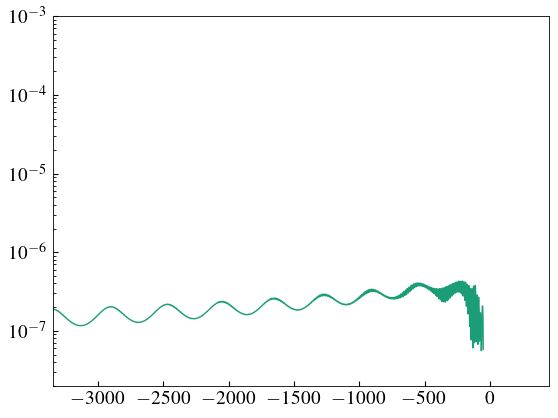

In [164]:
plt.yscale('log')
plt.ylim(ymax=1e-3)
plt.ylim(ymin=2e-8)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)
plt.plot(t_intrp5/(M0*MTSUN_SI),abs(hp_intrp5+1j*hc_intrp5)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode5polfac))
#print(sph33)

100%|█████████████████████████████████| 158636/158636 [00:56<00:00, 2812.52it/s]


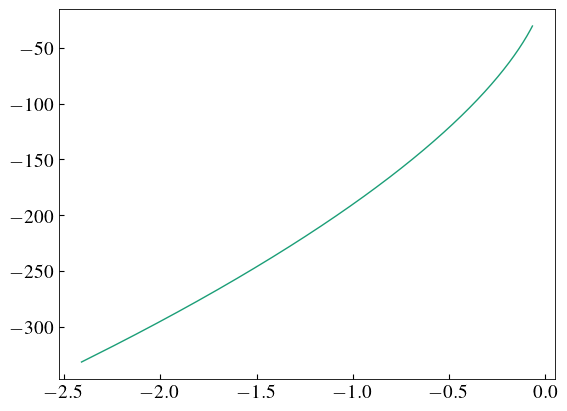

In [165]:
M0=30
q=2
e0=0.12
l0=-0.181
flow=21.541668606103567
inc=10*np.pi/180
d0=1
delta_t=1./4096
x0=xlow=0.046415888336127795
eta=neu=nu=q/(1+q)**2
Delta=math.sqrt(1-(4*neu))


kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": 0.01,
    "physicalUnits":True,
    "M": M0,
    "D":d0,
    "include_zero_ecc":True,
    }


method = "ResidualAmplitude"
origin = "LAL"
dataDict2 = load_waveform(origin, **kwargs)
return_dict = measure_eccentricity(fref_in=30,method=method,dataDict=dataDict2)

gwecc_object = return_dict["gwecc_object"]
Time_data = gwecc_object.get_omega22_average()[0]  #extract the time values
Omega_avg = gwecc_object.get_omega22_average()[1]

phs=Time_data*Omega_avg
plt.plot(Time_data,phs)
return_dict1 = measure_eccentricity(tref_in=Time_data,method=method,dataDict=dataDict2)
Fvec = Omega_avg/(2*PI) #Average frequency array

Fvec=Fvec*(M0*MTSUN_SI)


Eccentricity_new = return_dict1["eccentricity"]
Mean_anomaly = return_dict1["mean_anomaly"]


xiVec=(np.pi*M*Fvec)
xVec=xiVec**(2/3)
vVec=xiVec**(1/3)
xVec = xVec #[:10000]

phase_EccTD, tVec_PN = PNparams(M0,q,d0,21.541668606103567,e0,delta_t) #??

lp=5
mp=5
    
j=0
h55=[]
h5_5=[]
for i in tqdm(xVec):    #tqdm(xVec) for status bar
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=Mean_anomaly[j]
    e=Eccentricity_new[j]
    psi= phs[j] #phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    h=amplitude_55(xi,x,nu,Delta,e) #### 22 mode requires additional  eccentricity input
    #print(h)    
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hl_m=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,+1)*mp*psi/2))/d
        
    h55.append(hlm)
    h5_5.append(hl_m)
        
conv_t = M0*MTSUN_SI
conv_h = G_SI*M0*MSUN_SI/(10**6 * PC_SI * d0)/C_SI/C_SI
    
sph55, sph5_5 = sph_harmonics(inc,lp)
    
h = np.multiply(h55,sph55) #+np.multiply(h2_2,sph2_2)
hp=(np.real(h)) 
hc=(np.imag(h)) 

mode5polfac=(330/(1*np.pi))**(1/2)
    
hp = np.array(hp) * conv_h
hc = np.array(hc) * conv_h
time = Time_data
hp_intrp_new = interp1d(time, hp, kind='cubic',fill_value='extrapolate')
hc_intrp_new = interp1d(time, hc, kind='cubic',fill_value='extrapolate')
t_intrp_new5 = np.arange(time[0], time[-1], delta_t)
hp_intrp_new5 = hp_intrp_new(t_intrp_new5)
hc_intrp_new5 = hc_intrp_new(t_intrp_new5)



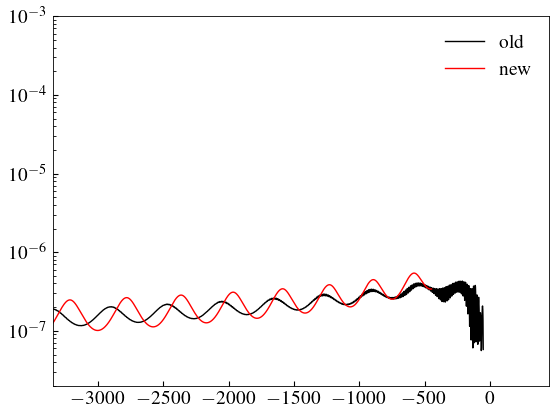

In [166]:
plt.yscale('log')
plt.ylim(ymax=1e-3)
plt.ylim(ymin=2e-8)
plt.xlim(xmin=-3350)
plt.xlim(xmax=450)
plt.plot(t_intrp5/(M0*MTSUN_SI),abs(hp_intrp5+1j*hc_intrp5)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode5polfac),'k-',label='old')
plt.plot(t_intrp_new5/(M0*MTSUN_SI),abs(hp_intrp_new5+1j*hc_intrp_new5)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode5polfac),'r-',label='new')
plt.legend()

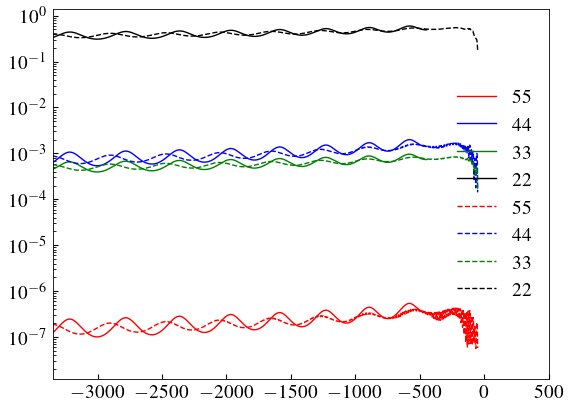

In [167]:
plt.yscale('log')
plt.xlim(xmin=-3350)
plt.xlim(xmax=500)
plt.plot(t_intrp_new5/(M0*MTSUN_SI),abs(hp_intrp_new5+1j*hc_intrp_new5)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode5polfac),'r',label='55')
plt.plot(t_intrp_new4/(M0*MTSUN_SI),abs(hp_intrp_new4+1j*hc_intrp_new4)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode4polfac),'b',label='44')
plt.plot(t_intrp_new3/(M0*MTSUN_SI),abs(hp_intrp_new3+1j*hc_intrp_new3)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode3polfac),'g',label='33')
plt.plot(t_intrp_new2/(M0*MTSUN_SI),abs(hp_intrp_new2+1j*hc_intrp_new2)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),'k',label='22')


plt.plot(t_intrp5/(M0*MTSUN_SI),abs(hp_intrp5+1j*hc_intrp5)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode5polfac),'r',linestyle='--',label='55')
plt.plot(t_intrp4/(M0*MTSUN_SI),abs(hp_intrp4+1j*hc_intrp4)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode4polfac),'b',linestyle='--',label='44')
plt.plot(t_intrp3/(M0*MTSUN_SI),abs(hp_intrp3+1j*hc_intrp3)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode3polfac),'g',linestyle='--',label='33')
plt.plot(t_intrp2/(M0*MTSUN_SI),abs(hp_intrp2+1j*hc_intrp2)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),'k',linestyle='--',label='22')

plt.legend()